# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mne.io import read_raw_edf
import os
import shutil

# 2. Organize files
## 2.a. Move files to appropriate directories
Write a function to allocate certain file types into designated folders.

In [3]:
def move_files(origin=None, extension='.edf', dest_folder='edf_data'):
    sourcefiles = os.listdir(origin)
    
    os.makedirs(dest_folder, exist_ok=True)
        
    for file in sourcefiles:
        if file.endswith(extension):
            shutil.move(os.path.join('' if origin is None else origin, file), os.path.join(dest_folder, file))

Move edf files to the `edf_data` folder.

In [4]:
move_files(extension='.edf', dest_folder='edf_data')

Move csv files to the `csv_data` folder.

In [5]:
move_files(extension='.csv', dest_folder='csv_data')

Move documents to the `docs` folder.

In [6]:
move_files(extension='.DOCX', dest_folder='docs')

## 2.b. Convert edf files into csv format and store in `converted_data` folder.

In [7]:
def convert_edf_to_csv(input='edf_data', dest_folder='converted_data', replace=False):
    os.makedirs(dest_folder, exist_ok=True)

    count = 0
    for file in os.listdir(input):
        if replace is True or (replace is False and file.removesuffix('.edf') + '.csv' not in os.listdir(dest_folder)):
                edf = read_raw_edf(os.path.join(input, str(file)))
                data = edf.get_data()
                channels = edf.ch_names
                
                df = pd.DataFrame(data).T
                df.columns = channels
                df.to_csv(os.path.join(dest_folder, str(file.removesuffix('.edf')) + '.csv'), index=False)

                count += 1
        else:
                print(f'File {file} is previously converted. Set parameter `replace=True` to convert again.')
    
    if count == 0:
        print('No file was converted.')
    if count > 0:
        print(f'Successfully converted {count} files.')

In [8]:
_input = 'edf_data'
_destination = 'converted_data'

In [9]:
convert_edf_to_csv(input=_input, dest_folder=_destination, replace=False)

File EXL6V2UAKMC8L0TG.edf is previously converted. Set parameter `replace=True` to convert again.
File poly3.edf is previously converted. Set parameter `replace=True` to convert again.
File poly2.edf is previously converted. Set parameter `replace=True` to convert again.
File polygraphie1.edf is previously converted. Set parameter `replace=True` to convert again.
File poly6.edf is previously converted. Set parameter `replace=True` to convert again.
File poly5.edf is previously converted. Set parameter `replace=True` to convert again.
File poly4.edf is previously converted. Set parameter `replace=True` to convert again.
No file was converted.


# 3. Data exploration
Import data.

In [10]:
os.listdir(_destination)

['poly4.csv',
 'poly5.csv',
 'poly6.csv',
 'polygraphie1.csv',
 '.DS_Store',
 'poly2.csv',
 'poly3.csv',
 'EXL6V2UAKMC8L0TG.csv']

In [11]:
df = pd.read_csv(os.path.join(_destination, 'poly2.csv'))
df.head()

,Resp nasal,Resp chest,Resp cpap,Sound SPL,Light,Pulsewave,Resp abdomen,Position,SaO2 SpO2,Pulse,ECG *,EMG right,Obstr,BR flow,HR central
0,20.000000,16.470588,0.000000,50.196078,-8.313725,32.549020,14.901961,51.000000,2.069606e-14,1.034803e-14,0.000027,49.803922,7.761021e-15,-1.293504e-15,72.0
1,19.164476,15.257828,-1.892024,35.686275,-8.278983,28.862286,13.512610,52.129741,-1.563454e+00,-1.499038e+00,-0.000004,49.877765,-1.147493e+01,-1.128461e+01,72.0
2,19.130704,14.855590,-3.298084,25.490196,-8.244799,31.764706,12.943375,53.241353,-3.103996e+00,-2.974473e+00,0.000059,50.022226,-2.001256e+01,-1.966733e+01,72.0
3,19.892901,15.255427,-4.189059,32.156863,-8.211199,33.699098,13.188367,54.334169,-4.620919e+00,-4.425648e+00,0.000278,50.214122,-2.543229e+01,-2.497794e+01,72.0
4,21.405236,16.407202,-4.571386,41.568627,-8.178208,31.372549,14.199331,55.407542,-6.113529e+00,-5.851927e+00,0.000427,50.416829,-2.776874e+01,-2.725682e+01,72.0


Count missing/unusal entries. Typically, the pulse of a patient should never be 0 or lower.

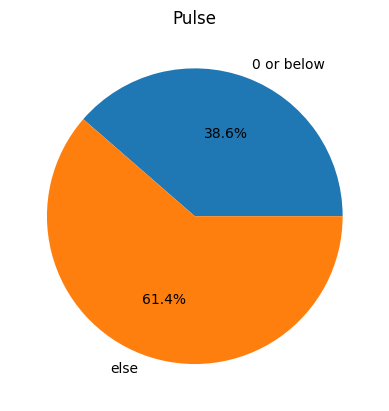

In [12]:
df_0 = df['Pulse'] <= 0

low_percent = sum(df_0) / len(df_0)
normal_percent = 1 - low_percent

labels = '0 or below', 'else'
sizes = [low_percent, normal_percent]

fig, ax = plt.subplots()
ax.set_title('Pulse')
ax.pie(sizes, labels=labels, autopct='%1.1f%%');

Line plot where the red sections depict unusal entries.

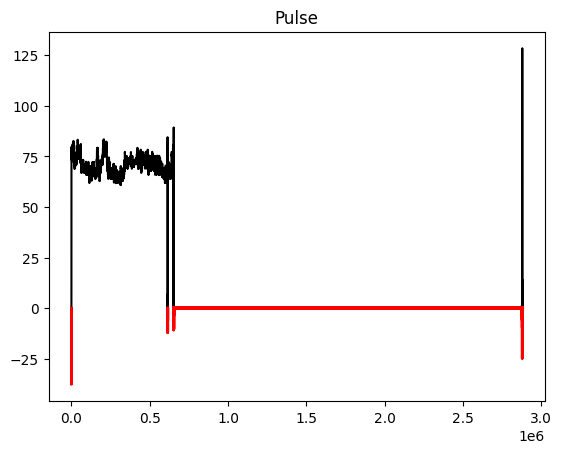

In [13]:
df_low_pulse = df['Pulse'] * df_0
df_low_pulse.replace(0, np.NaN, inplace=True)
df['Pulse'].plot(title='Pulse', c='k')
df_low_pulse.plot(c='r', linewidth=2);

This unusal pattern persists with other parameters as well.

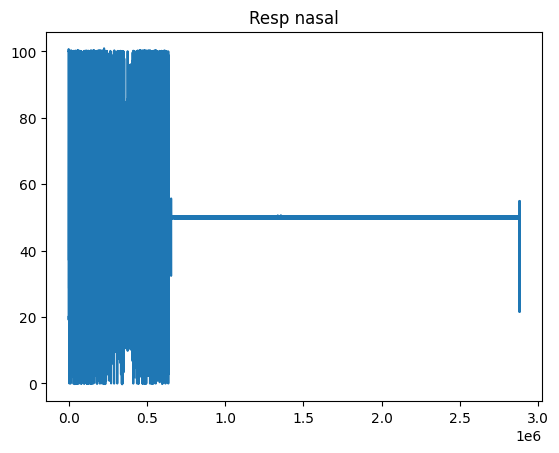

In [14]:
df['Resp nasal'].plot(title='Resp nasal');

The patient appeared to be measured for only 1h22'. For a more accurate depiction, only the entries from the beginning are selected for further plots.

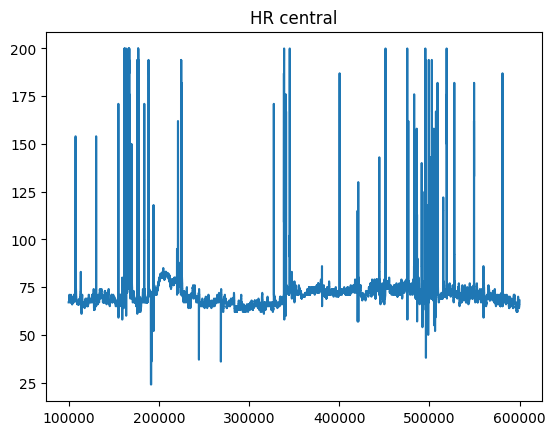

In [15]:
df_part_1 = df.loc[100_000 : 600_000]
df_part_1['HR central'].plot(title='HR central');

In [20]:
def plot_non_overlapping_lines(df=df_part_1, title='Poly2_edf sampling at 100.00 Hz', xlabel='Time (per 1/100 second)', export='poly2.svg'):
    fig, ax = plt.subplots(nrows=15, ncols=1, sharex=True, figsize=(25, 4))
    fig.suptitle(title)
    
    yprops = dict(rotation=0,
                  horizontalalignment='right',
                  verticalalignment='center',
                  x=-0.01)
    
    for i in range(len(df.columns)):
        ax[i].set_ylabel(df.columns[i], **yprops)
        ax[i].set_yticks([])
        ax[i].set_xlabel(xlabel)
        ax[i].margins(x=0)
        ax[i].plot(df.index, df.iloc[:, i],
                   linewidth=0.3)
        
    if export is None:
        pass
    else:
        os.makedirs('./exports', exist_ok=True)
        plt.savefig(os.path.join('./exports', export), bbox_inches='tight')

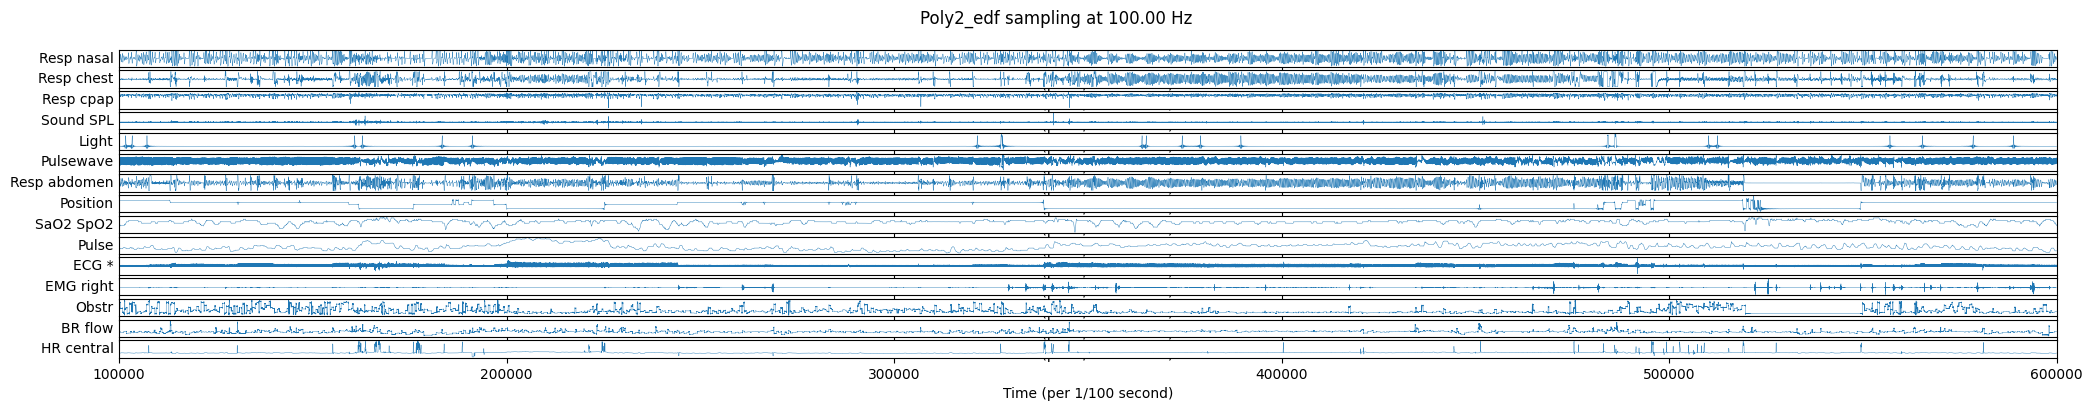

In [21]:
plot_non_overlapping_lines(df_part_1, title='Poly2_edf sampling at 100.00 Hz', xlabel='Time (per 1/100 second)', export='poly2.svg')